<a href="https://colab.research.google.com/github/ahmadijo/SPOD/blob/main/SPOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import timeit
import os


from scipy import interpolate
from numpy.lib.function_base import meshgrid

## Creating a grid that reads velocity and vorticity data from the results of CFD simulation

In [ ]:
nx = 80
ny = nx//2
nt = 640
x = np.linspace(0,0.1,nx+1)
y = np.linspace(0,0.05,ny+1)
x, y = meshgrid(x, y)

#u = np.zeros((nt,x.shape[0],x.shape[1]))
#v = np.zeros((nt,x.shape[0],x.shape[1]))
#W = np.zeros((nt,x.shape[0],x.shape[1]))

In [ ]:
with open('v.npy', 'wb') as f:
    np.save(f, v)

In [ ]:
with open('u.npy', 'rb') as f:
    u = np.load(f)
with open('v.npy', 'rb') as f:
    v = np.load(f)
with open('W.npy', 'rb') as f:
    W = np.load(f)


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/2D/'
f_list = os.listdir(path='/content/drive/MyDrive/Colab Notebooks/2D')

for n in range(u.shape[0]):
  print(n)
  file_path = path+f_list[n]
  f = open(file_path, "r") 

  # Read and ignore header lines
  header = f.readline()

  data = []
  for line in f:
    line = line.strip()
    columns = line.split(',')
    data.append([float(columns[2])*-1-0.06,
                 float(columns[1])*-1,
                 float(columns[4])*-1,
                 float(columns[3])*-1,
                 float(columns[5]),
                 0
    ])

  f.close()
  data = np.array(data)

  for i in range(u.shape[1]):
    for j in range(u.shape[2]):
      data[:,5] = (data[:,0]-x[i,j])**2 + (data[:,1]-y[i,j])**2
      sort_data = data[data[:, 5].argsort()]
      u[n,i,j] = np.mean(sort_data[:4,2])
      v[n,i,j] = np.mean(sort_data[:4,3])
      W[n,i,j] = np.mean(sort_data[:4,4])

with open('u2.npy', 'wb') as f:
    np.save(f, u)
with open('v2.npy', 'wb') as f:
    np.save(f, v)
with open('W2.npy', 'wb') as f:
    np.save(f, W)

## Contour of mean $u$ and $v$ velocities just downstream of the cylinders

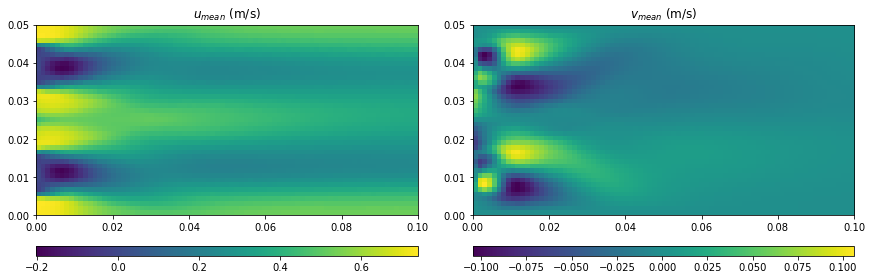

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)


im = axs[0].imshow(np.mean(u, axis=0), extent=[0,0.1,0,0.05])
axs[0].set_title('$u_{mean}$ (m/s)')
#axs[0].axes.xaxis.set_visible(False)
#axs[0].axes.yaxis.set_visible(False)
fig.colorbar(im, ax=axs[0], location='bottom')

im = axs[1].imshow(np.mean(v, axis=0), extent=[0,0.1,0,0.05])
axs[1].set_title('$v_{mean}$ (m/s)')
fig.colorbar(im, ax=axs[1], location='bottom')


## Animation of vorticity over about 1 second

In [ ]:
%matplotlib inline
rc('animation', html='jshtml')

fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
plt.close(fig)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

ims = []
for i in range(u.shape[0]//2):
    im = ax.imshow(W[i,:,:], animated=True)
    ims.append([im])
fig.colorbar(im, location='bottom')
anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()
anim

substracting the mean value (in time) from the snapshats of $u$ and $v$

In [ ]:
u = u - np.mean(u, axis=0)
v = v - np.mean(v, axis=0)

Performing Spectral Proper Orthogonal Decomposition (SPOD)

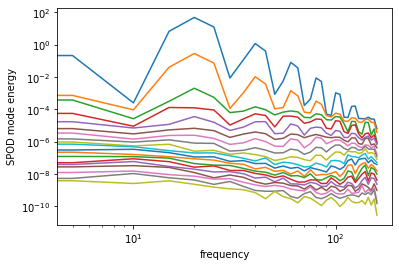

In [ ]:
import h5py
from spod import spod

dt = 0.003125

result = spod(u, dt=dt)

plt.figure()
plt.loglog(result["f"], result["L"])
plt.xlabel("frequency")
plt.ylabel("SPOD mode energy")
plt.show()

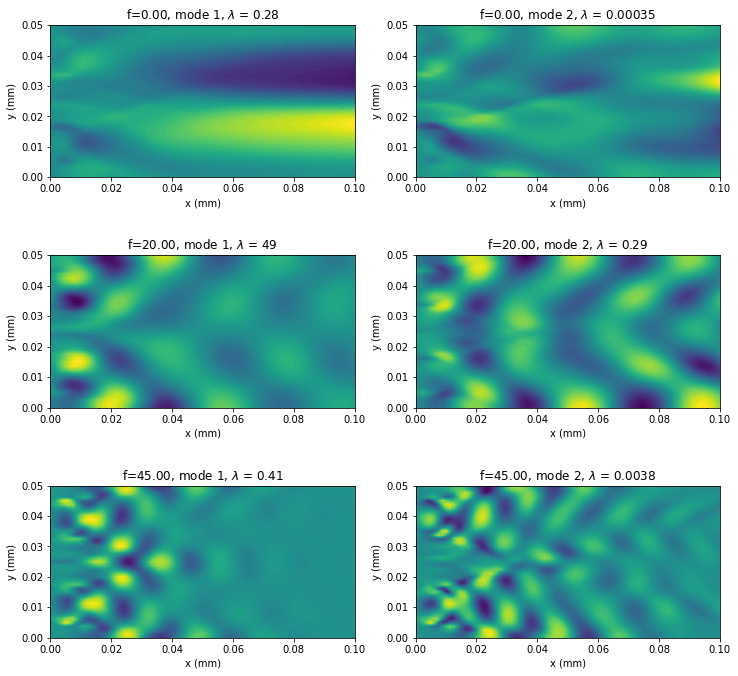

In [ ]:
#   Second, we visualize the 1st and 2nd SPOD modes at three frequencies.
plt.figure(figsize=(12, 12))
count = 1
for fi in [1, 5, 10]:
    for mi in [1, 2]:
        plt.subplot(3, 2, count)
        P = np.real(result["P"][fi - 1, :, :, mi - 1])
        vmax = np.max(np.abs(P))
        plt.contourf(x, y, P, 64, vmin=-vmax, vmax=vmax)
        plt.axis("scaled")
        plt.xlabel("x (mm)")
        plt.ylabel("y (mm)")
        plt.title(
            "f=%.2f, mode %d, $\lambda$ = %.2g"
            % (result["f"][fi - 1], mi, result["L"][fi - 1, mi - 1])
        )
        count += 1

plt.show()